# 『ウェブ最適化ではじめる機械学習』の写経

In [1]:
import os
import sys

sys.path.append(os.path.join('../.venv/Lib/site-packages/'))

In [2]:
from matplotlib import pyplot as plt

## Chap. 5 bandit algorithms

### 環境の設定

In [3]:
import numpy as np
np.random.seed(0)

In [4]:
n_arms = 4

In [5]:
class Env(object):
    thetas = [0.1, 0.1, 0.2, 0.3]
    
    def react(arm):
        return 1 if np.random.random() < Env.thetas[arm] else 0
    
    def opt():
        return np.argmax(Env.thetas)

### $\epsilon$ greedy

In [6]:
class EpsilonGreedyAgent(object):
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        
    def get_arm(self):
        if np.random.random() < self.epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(self.values)
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = (
            (self.counts[arm]-1) * self.values[arm] + reward
        ) / self.counts[arm]

In [7]:
def sim(Agent, N=1000, T=1000, **kwargs):
    selected_arm = [[0 for _ in range(T)] for _ in range(N)]
    earned_rewards = [[0 for _ in range(T)] for _ in range(N)]
    
    for n in range(N):
        agent = Agent(**kwargs)
        for t in range(T):
            arm = agent.get_arm()
            reward = Env.react(arm)
            agent.sample(arm, reward)
            selected_arm[n][t] = arm
            earned_rewards[n][t] = reward
    return np.array(selected_arm), np.array(earned_rewards)

In [8]:
arms_eg, rewards_eg = sim(EpsilonGreedyAgent)
acc = np.mean(arms_eg == Env.opt(), axis=0)

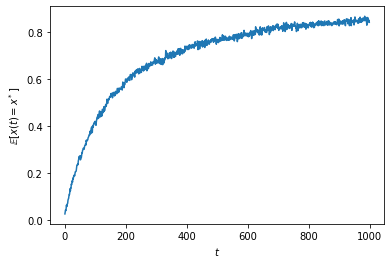

In [9]:
plt.plot(acc)
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.show()

In [10]:
# 常に最適解を提示し続ける
class OracleAgent(object):
    def __init__(self):
        self.arm = Env.opt()
        
    def get_arm(self):
        return self.arm
    
    def sample(self, arm, reward):
        pass

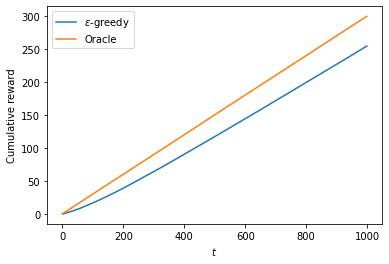

In [11]:
arms_o, rewards_o = sim(OracleAgent)
plt.plot(np.mean(np.cumsum(rewards_eg, axis=1), axis=0), label=r'$\epsilon$-greedy')
plt.plot(np.mean(np.cumsum(rewards_o, axis=1), axis=0), label=r'Oracle')
plt.xlabel(r'$t$')
plt.ylabel('Cumulative reward')
plt.legend()
plt.show()

### Annealing $\epsilon$ greedy

In [12]:
class AnnealingEpsilonGreedyAgent(object):
    def __init__(self, epsilon=1.0):
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        
    def get_arm(self):
        if np.random.random() < self.epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(self.values)
        self.epsilon *= 0.99
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = (
            (self.counts[arm]-1) * self.values[arm] + reward
        ) / self.counts[arm]

In [13]:
arms_aeg, rewards_aeg = sim(EpsilonGreedyAgent)

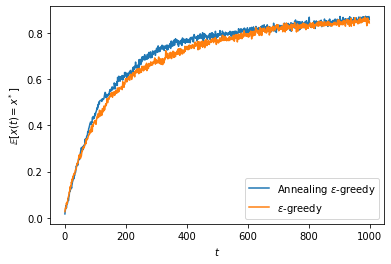

In [14]:
plt.plot(np.mean(arms_aeg == Env.opt(), axis=0), label=r'Annealing $\epsilon$-greedy')
plt.plot(np.mean(arms_eg == Env.opt(), axis=0), label=r'$\epsilon$-greedy')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

### softmax

In [15]:
class SoftmaxAgent(object):
    def __init__(self, tau=.05):
        self.tau = tau
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        
    def softmax_p(self):
        logit = self.values / self.tau
        logit = logit - np.max(logit) # logit が0に近いと exp にかけたときにオーバーフローしてしまうことを避ける
        return np.exp(logit) / sum(np.exp(logit))
    
    def get_arm(self):
        return np.random.choice(n_arms, p=self.softmax_p())
        
    def sample(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        self.values[arm] = (
            (self.counts[arm] - 1) * self.values[arm] + reward
        ) / self.counts[arm]

In [16]:
arms_sm, rewards_sm = sim(SoftmaxAgent)

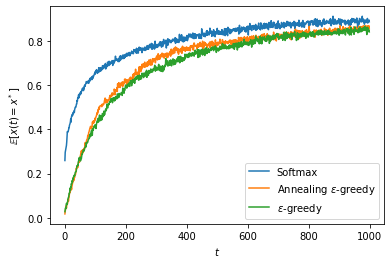

In [17]:
plt.plot(np.mean(arms_sm == Env.opt(), axis=0), label=r'Softmax')
plt.plot(np.mean(arms_aeg == Env.opt(), axis=0), label=r'Annealing $\epsilon$-greedy')
plt.plot(np.mean(arms_eg == Env.opt(), axis=0), label=r'$\epsilon$-greedy')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

### Annealing sotfmax

In [18]:
class AnnealingSoftmaxAgent(object):
    def __init__(self, tau=1000.):
        self.tau = tau
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        
    def softmax_p(self):
        logit = self.values / self.tau
        logit = logit - np.max(logit)
        return np.exp(logit) / sum(np.exp(logit))
    
    def get_arm(self):
        arm = np.random.choice(n_arms, p=self.softmax_p())
        self.tau *= 0.9
        return arm
        
    def sample(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        self.values[arm] = (
            (self.counts[arm] - 1) * self.values[arm] + reward
        ) / self.counts[arm]

In [19]:
arms_asm, rewards_asm = sim(AnnealingSoftmaxAgent)

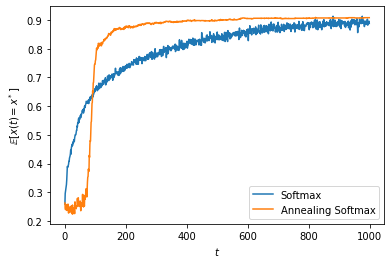

In [20]:
plt.plot(np.mean(arms_sm == Env.opt(), axis=0), label=r'Softmax')
plt.plot(np.mean(arms_asm == Env.opt(), axis=0), label=r'Annealing Softmax')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

### Thompson sampling

In [21]:
class BernoulliTSAgent(object):
    def __init__(self):
        self.counts = [0 for _ in range(n_arms)]
        self.wins = [0 for _ in range(n_arms)]
        
    def get_arm(self):
        beta = lambda N, a: np.random.beta(a+1, N-a+1)
        result = [beta(self.counts[i], self.wins[i]) for i in range(n_arms)]
        arm = result.index(max(result))
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        self.wins[arm] = self.wins[arm] + reward

In [22]:
arms_ts, rewards_ts = sim(BernoulliTSAgent)

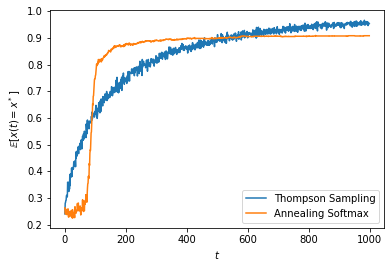

In [23]:
plt.plot(np.mean(arms_ts == Env.opt(), axis=0), label=r'Thompson Sampling')
plt.plot(np.mean(arms_asm == Env.opt(), axis=0), label=r'Annealing Softmax')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

### UCB Algorithms

In [24]:
class UCBAgent(object):
    def __init__(self):
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0 for _ in range(n_arms)]
        
    def calc_ucb(self, arm):
        ucb = self.values[arm]
        ucb += np.sqrt(np.log(sum(self.counts)) / (2 * self.counts[arm]))
        return ucb
        
    def get_arm(self):
        # 一回も選択されていない腕があればそれを選ぶ
        if 0 in self.counts:
            arm = self.counts.index(0)
        else:
            ucb = [self.calc_ucb(arm) for arm in range(n_arms)]
            arm = ucb.index(max(ucb))
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        self.values[arm] = (
            (self.counts[arm] - 1) * self.values[arm] + reward
        ) / self.counts[arm]

In [25]:
arms_ucb, rewards_ucb = sim(UCBAgent)

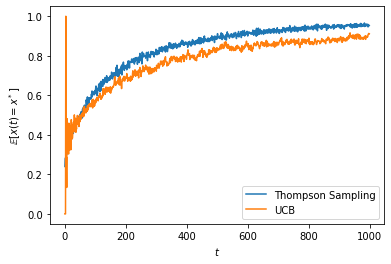

In [26]:
plt.plot(np.mean(arms_ts == Env.opt(), axis=0), label=r'Thompson Sampling')
plt.plot(np.mean(arms_ucb == Env.opt(), axis=0), label=r'UCB')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()